## Neural Style Transfer
 Then there's the image that gives us the style that we want to convert our image into. We'll call that the style image. From these, we'll create a new image that we'll call the generated image. It would be created over many iterations initially looking very much like the content image but over time it will take on the attributes of the style image. Using a pre-trained CNN, for example, VGG-19, we can extract the content features from the content image. We'll represent these features as the last block in the network here, and the style is also extracted by using a pre-trained CNN. Style information can be extracted from every layer in the network, and this is represented here by the arrows coming out of each block in the network diagram. We'll then initialize our generated image from the content image. The model can compare the generated image with the content image by calculating what's called a content loss. On every iteration, it checks how much of the original content is present in the generated image. As you can imagine on the first iteration, the content loss will be close or equal to zero depending on the initialization of the pre-trained CNN. Over several iterations, as you will see, the content loss may increase as the generated image is modified to incorporate the style information. Now, this might seem counterintuitive, but increasing the content loss is actually a good thing because that would indicate that there are differences between the generated image and the original content image. The loss would be zero if they were identical. But of course, you don't want the loss to get too high or you'd lose the features and attributes of the original image. Similarly, you want to reduce the style loss because we'd like some of its attributes to be in the generated image. It's ultimately a balancing game.

In [1]:
IMAGE_DIR = 'images'

# create directory
!mkdir {IMAGE_DIR}

# download images to the directory you just created
!wget -q -O ./images/cafe.jpg https://cdn.pixabay.com/photo/2018/07/14/15/27/cafe-3537801_1280.jpg
!wget -q -O ./images/swan.jpg https://cdn.pixabay.com/photo/2017/02/28/23/00/swan-2107052_1280.jpg
!wget -q -O ./images/tnj.jpg https://i.dawn.com/large/2019/10/5db6a03a4c7e3.jpg
!wget -q -O ./images/rudolph.jpg https://cdn.pixabay.com/photo/2015/09/22/12/21/rudolph-951494_1280.jpg
!wget -q -O ./images/dynamite.jpg https://cdn.pixabay.com/photo/2015/10/13/02/59/animals-985500_1280.jpg
!wget -q -O ./images/painting.jpg https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg

print("image files you can choose from: ")
!ls images

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


image files you can choose from: 


'wget' is not recognized as an internal or external command,
operable program or batch file.
'ls' is not recognized as an internal or external command,
operable program or batch file.


In [19]:
content_path= f'cafe.jpg'
style_path= f'painting.jpg'


Imagine you have two images: one is a photograph of a serene mountain landscape, and the other is a famous painting by Van Gogh, such as "Starry Night." Now, what if we could combine the style of Van Gogh's painting with the content of the mountain landscape? That's where style transfer comes into play!

Style transfer is a technique that allows us to take the artistic style of one image and apply it to another image, creating a unique blend of both. It's like giving your photographs an artistic makeover. Pretty cool, right?

Now, let me break it down for you. The magic behind style transfer lies in deep learning and convolutional neural networks (CNNs). These fancy terms might sound intimidating, but fear not, my dear students. I'll make them as approachable as your favorite ice cream flavor.

In simple terms, a CNN is a type of artificial neural network that excels at recognizing patterns in images. It can learn to understand the visual features that make an image unique, such as edges, textures, and colors.

During style transfer, we utilize a pre-trained CNN, like the popular VGG network. This network has been trained on millions of images and has learned to capture the essence of various artistic styles. Think of it as an art connoisseur with an extensive knowledge of different painting techniques.

Here's how the style transfer process works:

1. **Content Image**: This is the photograph of the mountain landscape. It provides the content or subject of our final image.

2. **Style Image**: This is the painting by Van Gogh, like "Starry Night." It provides the desired artistic style we want to apply.

3. **Convolutional Neural Network**: We pass both the content and style images through the CNN, layer by layer. As they travel through the network, the CNN analyzes the visual features of each image.

4. **Content Representation**: At a certain layer in the network, we extract the content representation of the content image. This representation captures the content-related features of the image, such as the shapes and structures.

5. **Style Representation**: Similarly, at different layers, we extract the style representation of the style image. This representation captures the texture, brushwork, and overall style characteristics.

6. **Loss Function**: To perform style transfer, we define a loss function that measures how different our generated image is from both the content representation and the style representation. We aim to minimize this loss to create a blended image that captures both content and style.

7. **Optimization**: We optimize the generated image by iteratively adjusting its pixels to minimize the loss function. This process gradually refines the image until it strikes a balance between content and style.

By repeating the optimization steps, we can achieve stunning results where the content of the mountain landscape is infused with the brushstrokes and artistic flair of Van Gogh's style.

Style transfer has opened up new possibilities in the fields of digital art, photography, and even cinematography. It allows us to create visually captivating images that blur the boundaries between reality and artistic expression.

So, style transfer is a fascinating technique that blends the content of one image with the style of another. It involves utilizing a pre-trained neural network, extracting content and style representations, defining a loss function, and optimizing the generated image. The result? A stunning fusion of content and artistic style.

 

**The lower level features define the style of your image and the higher level features define the content of your image. Looking at the layers of the CNN, you can get the style from the lower numbered layers closer to the input, and it can retrieve the content of the image from the higher number layers deeper in the network. **

As oftentimes, the very last layer isn't the best one to use. This is because by the very last layer, the filters have reduced the image to very small images containing extracted ***features***
 
 



### Loading the pre-trained model and freezing the hidden layers.

In [20]:
import tensorflow as tf 
from tensorflow import keras 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
from IPython.display import display as display_fn
from IPython.display import Image, clear_output


In [21]:
content_layers=['block5_conv2']

style_layers=['block1_conv1',
              'block2_conv1',
              'block3_conv1',
              'block4_conv1',
              'block5_conv1',]

layer_names= content_layers+ style_layers

NUM_CONTENT_LAYERS= len(content_layers)

In [22]:
def vgg_model(layer_names):
  vgg= tf.keras.applications.vgg19.VGG19(include_top= False, weights='imagenet')

  vgg.trainable= False  ## Freezing the hidden layers.

  content_output= [vgg.get_layer(layer).output for layer in content_layers]
  style_output= [vgg.get_layer(layer).output for layer in style_layers]

  model = tf.keras.Model(inputs= vgg.input, outputs= content_output +style_output )

  return content_output,style_output,model


In [23]:
content_output,style_output,model= vgg_model(layer_names)

### Defining the losses 

In [6]:
def get_content_loss(content, targets):
  return 0.5 * tf.reduce_sum(tf.square(content-targets))

In [7]:
def get_style_loss(style, targets):
  style_gram= gram_matrix(style)
  targets_gram= gram_matrix(targets)
  return tf.reduce_sum(tf.square(style_gram- targets_gram))

In [8]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / (num_locations)



#### Preprocessing the Image.
Here's a step-by-step explanation of the function:

1) img = tf.keras.preprocessing.image.load_img(image_path): Loads the image from the specified image_path using the load_img function from TensorFlow's image preprocessing module.

2) img = tf.keras.preprocessing.image.img_to_array(img): Converts the loaded image into a NumPy array. This allows us to manipulate and process the image using numerical operations.

3) img = tf.keras.applications.vgg19.preprocess_input(img): Preprocesses the image according to the requirements of the VGG19 model. The VGG19 network expects input images to be preprocessed in a specific way, which involves mean subtraction and channel reordering. This preprocessing step helps align the image with the pre-trained model's expectations.

4) img = np.expand_dims(img, axis=0): Expands the dimensions of the image array to create a batch dimension. The VGG19 model expects input in the form of a batch, even if we are processing a single image. Adding the batch dimension ensures compatibility with the model's input shape.

Returns the preprocessed image as a NumPy array.

By applying these operations, the preprocess_image function prepares the input image for style transfer by converting it into a suitable format and applying the necessary preprocessing steps required by the VGG19 model.

In [24]:
def preprocess_img(img_path):
  img= tf.keras.preprocessing.image.load_img(img_path)
  img= tf.keras.preprocessing.image.img_to_array(img)
  img=tf.cast(img, tf.float32)
  img= tf.keras.applications.vgg19.preprocess_input(img)
  img= np.expand_dims(img, axis=0)
  return img


#### Deprocess Image
Here's a step-by-step explanation of the function:

1) img = img.reshape((img.shape[1], img.shape[2], 3)): Reshapes the image tensor to its original shape. During the style transfer process, the image was preprocessed to fit into the VGG model, which involves reshaping and normalizing the image.

2) img[:, :, 0] += 103.939, img[:, :, 1] += 116.779, img[:, :, 2] += 123.68: Reverses the preprocessing step that subtracted the mean values from the image channels. The values 103.939, 116.779, and 123.68 are the mean values used for preprocessing in the VGG network.

3) img = img[:, :, ::-1]: Converts the image from the BGR color format to the more common RGB format. The style transfer process typically operates on images in the BGR format, so this step corrects it to the RGB format.

4) img = np.clip(img, 0, 255).astype('uint8'): Clips the pixel values to ensure they fall within the valid range of 0 to 255. Some optimization methods during style transfer may cause pixel values to exceed this range, so this step ensures the image is properly scaled.

Returns the deprocessed image as a NumPy array with data type 'uint8', which is the standard data type for representing pixel values in images.

By applying these operations, the deprocess_image function reverses the preprocessing steps, allowing us to visualize the final stylized image in its original form. 

In [ ]:
def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]  # Convert from BGR to RGB
    img = np.clip(img, 0, 255).astype('uint8')
    return img


In [ ]:
vgg= tf.keras.applications.VGG19(include_top= False , weights= 'imagenet' )

In [25]:
def get_style_content_loss(content_features, content_targets, style_features, style_targets, content_weight, style_weight):

  content_loss= tf.add_n([get_content_loss(content_features, content_targets) for content_features, content_targets in zip(content_features, content_targets)])
  content_loss= content_loss * content_weight / len(content_layers)

  style_loss = tf.add_n([get_style_loss(style_features, style_targets) for style_features, style_targets in zip(style_features, style_targets)])
  style_loss = style_loss * style_weight / len(style_layers)

  total_loss= content_loss + style_loss
  
  return total_loss
 

In [26]:
def calculate_gradients(generated_image,content_features, style_features, content_weight, style_weight):

  with tf.GradientTape() as tape:

    content_targets= get_content_layer_output(generated_image)

    style_targets= get_style_layer_output(generated_image)

    loss= get_style_content_loss(content_features, content_targets, style_features, style_targets, content_weight, style_weight)

  gradients= tape.gradient(loss, generated_image)

  return gradients

In [27]:
def update_image_with_style(generated_image,content_features, style_features, content_weight, style_weight, optimizer):

  gradients= calculate_gradients(generated_image,content_features, style_features,content_weight, style_weight)

  optimizer.apply_gradients([(gradients,generated_image)])

  generated_image.assign(tf.clip_by_value(generated_image,clip_value_min= 0.0, clip_value_max= 255.0 ))



In [28]:
def get_content_layer_output(image):
  # Assuming image is preprocessed.

  outputs= model(image)
  
  content_output= outputs[:NUM_CONTENT_LAYERS]

  return content_output



In [29]:
def get_style_layer_output(image):
  # Assuming image is preprocessed.

  outputs= model(image)

  style_output= outputs[NUM_CONTENT_LAYERS:]

  return style_output

In [30]:
def tensor_to_image(tensor):
  '''converts a tensor to an image'''
  tensor_shape = tf.shape(tensor)
  number_elem_shape = tf.shape(tensor_shape)
  if number_elem_shape > 3:
    assert tensor_shape[0] == 1
    tensor = tensor[0]
  return tf.keras.preprocessing.image.array_to_img(tensor) 

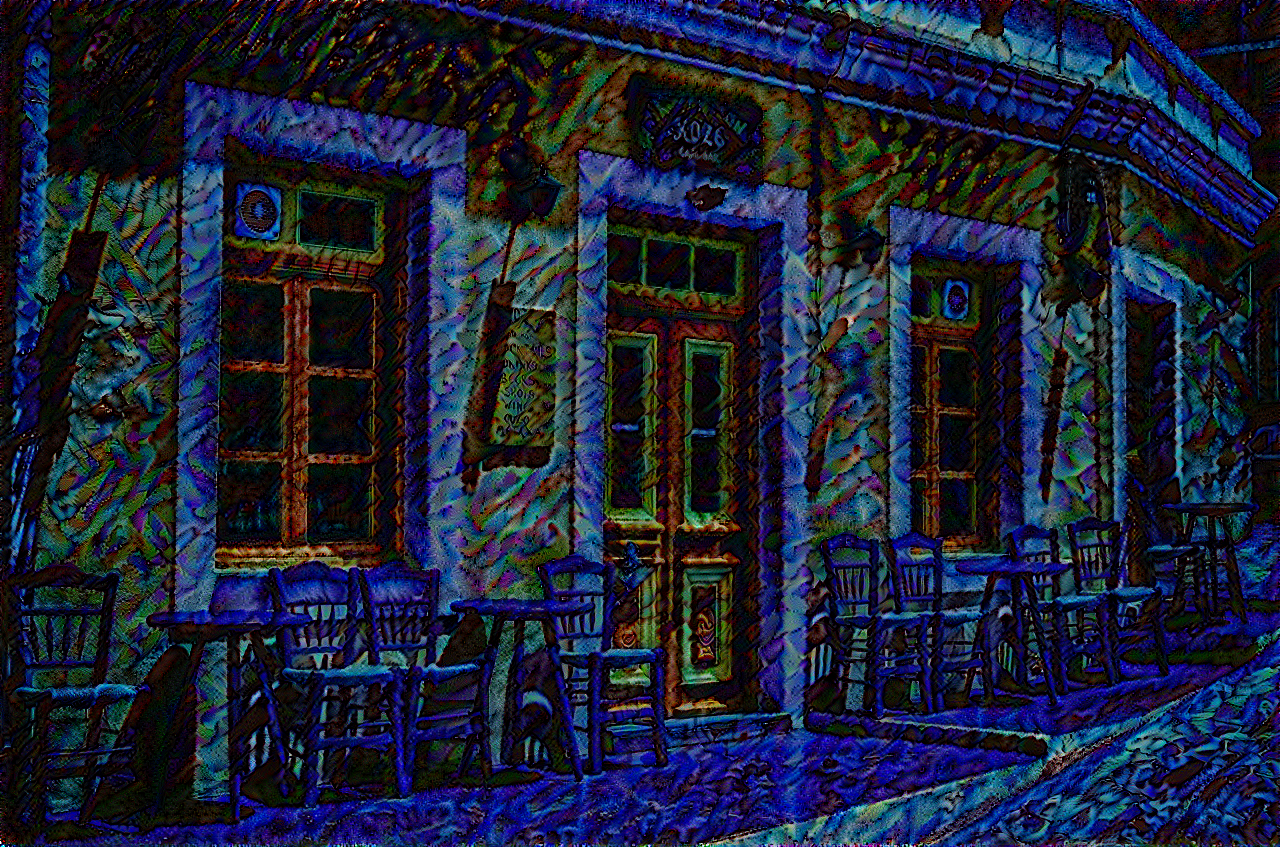

Train Step: 240
......

In [ ]:
def generate_styled_img(content_image_path, style_image_path,num_iter= 1000, steps_per_epoch=30,content_weight= 1e2, style_weight= 1e-2):
  content_image = preprocess_img(content_image_path)
  style_image= preprocess_img(style_image_path)

  generated_image= tf.cast(content_image, dtype= tf.float32 )
  generated_image= tf.Variable(content_image)

  content_features= get_content_layer_output(content_image)
  style_features= get_style_layer_output(style_image)

  optimizer= tf.optimizers.Adam(learning_rate= 2.0)

  image=[]
  steps=0

  for i in range(num_iter):
    for m in range(steps_per_epoch):
      steps+=1
 
      update_image_with_style(generated_image, content_features, style_features, content_weight , style_weight, optimizer)
      
      if((m+1)%10 ==0):
        image.append(generated_image)
      
      print(".", end='')
      
    clear_output(wait=True)
    display_image= tensor_to_image(generated_image)
    display_fn(display_image)

    print("Train Step:" , steps)


  generated_image= tf.cast(generated_image , dtype=tf.uint8)
      
generate_styled_img(content_path, style_path, num_iter=30)
       
    


    



Here's a step-by-step explanation of the function:

content_image = preprocess_image(content_image_path): Preprocesses the content image by using the preprocess_image function. This step converts the content image into a suitable format for style transfer.

style_image = preprocess_image(style_image_path): Preprocesses the style image by using the preprocess_image function. This step converts the style image into a suitable format for style transfer.

generated_image = tf.Variable(content_image, dtype=tf.float32): Initializes the generated image as a TensorFlow variable. The generated image starts with the content image as its initial value.

optimizer = tf.optimizers.Adam(learning_rate=2.0): Sets up the Adam optimizer with a learning rate of 2.0. The optimizer is responsible for updating the generated image based on the computed loss.

The loop starts, iterating for num_iterations:

a. with tf.GradientTape() as tape:: Opens a gradient tape context. This allows us to track the operations and compute gradients with respect to the variables involved.

b. tape.watch(generated_image): Ensures that the generated image is watched by the gradient tape, so gradients can be calculated with respect to it.

c. content_outputs = vgg(content_image), style_outputs = vgg(style_image), generated_outputs = vgg(generated_image): Passes the content image, style image, and generated image through the VGG network to obtain their respective outputs at the specified layers.

e. gradients = tape.gradient(total_loss, generated_image): Computes the gradients of the total loss with respect to the generated image.

f. optimizer.apply_gradients([(gradients, generated_image)]): Updates the generated image based on the computed gradients using the Adam optimizer.

g. Prints the loss at regular intervals for monitoring the progress of the style transfer process.

generated_image = generated_image.numpy().squeeze(): Converts the generated image from a TensorFlow variable to a NumPy array and removes the batch dimension.

generated_image = deprocess_image(generated_image): Deprocesses the generated image using the deprocess_image function to obtain the final stylized image.

Displays the generated image using plt.imshow() and plt.show().

By applying these operations within the loop, the generate_image function iteratively optimizes the generated image to minimize the content loss and style loss, thereby creating a stylized image that combines the content of the content image with the style of the style image.